**LifeCare Clinics**

Build a Data Analysis Pipeline using Python.  
Your script must ingest raw patient data,   
clean it, calculate statistical summaries for the doctors,   
and automatically flag patients with irregular vitals (outliers) for immediate medical review.

In [6]:
import csv
filepath = "data/patient_vitals.csv"
def load_data(filepath):
    """
    Load patient vital sign data from a CSV file.

    The function reads a CSV file containing patient records, validates
    numeric fields, and returns a list of dictionaries where each dictionary
    represents one patient.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        list[dict]: A list of patient records. Invalid rows are skipped.
    """
    patient_records = []

    try:
        with open(filepath, newline="") as csv_file:
            csv_reader = csv.DictReader(csv_file)

            for row in csv_reader:
                try:
                    patient_record = {
                        "patient_id": int(row["patient_id"]),
                        "age": int(row["age"]),
                        "temperature": float(row["temperature"]),
                        "heart_rate": int(row["heart_rate"]),
                        "systolic_bp": int(row["systolic_bp"]),
                        "oxygen_saturation": int(row["oxygen_saturation"]),
                    }
                    patient_records.append(patient_record)

                except ValueError:
                    print("ValueError: Invalid numeric data in row:", row)

    except FileNotFoundError:
        print(f"FileNotFoundError: '{filepath}' not found.")

    return patient_records

load_data(filepath)

[{'patient_id': 101,
  'age': 25,
  'temperature': 36.6,
  'heart_rate': 72,
  'systolic_bp': 118,
  'oxygen_saturation': 98},
 {'patient_id': 102,
  'age': 34,
  'temperature': 37.1,
  'heart_rate': 80,
  'systolic_bp': 122,
  'oxygen_saturation': 97},
 {'patient_id': 103,
  'age': 45,
  'temperature': 36.8,
  'heart_rate': 76,
  'systolic_bp': 130,
  'oxygen_saturation': 96},
 {'patient_id': 104,
  'age': 52,
  'temperature': 37.5,
  'heart_rate': 88,
  'systolic_bp': 140,
  'oxygen_saturation': 95},
 {'patient_id': 105,
  'age': 61,
  'temperature': 36.4,
  'heart_rate': 70,
  'systolic_bp': 135,
  'oxygen_saturation': 94},
 {'patient_id': 106,
  'age': 29,
  'temperature': 36.9,
  'heart_rate': 75,
  'systolic_bp': 120,
  'oxygen_saturation': 99},
 {'patient_id': 107,
  'age': 38,
  'temperature': 37.0,
  'heart_rate': 82,
  'systolic_bp': 125,
  'oxygen_saturation': 97},
 {'patient_id': 108,
  'age': 47,
  'temperature': 38.1,
  'heart_rate': 92,
  'systolic_bp': 145,
  'oxygen_sa

In [7]:
# Load the data
data = load_data("data/patient_vitals.csv")

# Print first 5 patient records
for data in data[:5]:
    print(data)


{'patient_id': 101, 'age': 25, 'temperature': 36.6, 'heart_rate': 72, 'systolic_bp': 118, 'oxygen_saturation': 98}
{'patient_id': 102, 'age': 34, 'temperature': 37.1, 'heart_rate': 80, 'systolic_bp': 122, 'oxygen_saturation': 97}
{'patient_id': 103, 'age': 45, 'temperature': 36.8, 'heart_rate': 76, 'systolic_bp': 130, 'oxygen_saturation': 96}
{'patient_id': 104, 'age': 52, 'temperature': 37.5, 'heart_rate': 88, 'systolic_bp': 140, 'oxygen_saturation': 95}
{'patient_id': 105, 'age': 61, 'temperature': 36.4, 'heart_rate': 70, 'systolic_bp': 135, 'oxygen_saturation': 94}


In [8]:
# ==========================
# Module 2: The Analytics Engine
# ==========================
import math
from collections import Counter

def calculate_mean(values):
    """Returns the arithmetic mean of a list of numbers."""
    if not values:
        raise ValueError("Cannot calculate mean of empty list.")
    return sum(values) / len(values)


def calculate_median(values):
    """Sorts the list and returns the middle value (median)."""
    if not values:
        raise ValueError("Cannot calculate median of empty list.")
    sorted_values = sorted(values)
    n = len(sorted_values)
    mid = n // 2
    if n % 2 == 0:
        return (sorted_values[mid - 1] + sorted_values[mid]) / 2
    else:
        return sorted_values[mid]


def calculate_mode(values):
    """Returns the most frequent value (mode) in the list."""
    if not values:
        raise ValueError("Cannot calculate mode of empty list.")
    frequency = Counter(values)
    return frequency.most_common(1)[0][0]


def calculate_outliers(values):
    """
    Returns a list of values that are outliers using the IQR method.

    IQR Logic:
        IQR = Q3 - Q1
        Lower Bound = Q1 - (multiplier * IQR)
        Upper Bound = Q3 + (multiplier * IQR)
    """
    if len(values) < 4:
        return []

    sorted_values = sorted(values)
    
    # Percentile function
    def percentile(sorted_list, percent):
        k = (len(sorted_list) - 1) * percent
        f = math.floor(k)
        c = math.ceil(k)
        if f == c:
            return sorted_list[int(k)]
        return sorted_list[f]*(c-k) + sorted_list[c]*(k-f)
    
    q1 = percentile(sorted_values, 0.25)
    q3 = percentile(sorted_values, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - 0.47 * iqr
    upper_bound = q3 + 0.47 * iqr

    return [v for v in sorted_values if v < lower_bound or v > upper_bound]


# ==========================
# Module 3: Reporting
# ==========================

def generate_summary_report(data):
    """
    Orchestrates the flow:
        - Extracts Heart Rate and Temperature from patient data
        - Runs Module 2 statistical functions
        - Prints a clean report
        - Flags patient_id for outliers
    Parameters:
        patients (list of dict): Patient records loaded from CSV
        multiplier (float): IQR multiplier for outlier detection
    """
    if not data:
        print("No patient data available.")
        return

    # Extract vitals
    heart_rates = [p["heart_rate"] for p in data]
    temperatures = [p["temperature"] for p in data]

    # Calculate statistics
    stats = {}
    stats["Heart Rate"] = {
        "mean": calculate_mean(heart_rates),
        "median": calculate_median(heart_rates),
        "mode": calculate_mode(heart_rates),
        "outliers": calculate_outliers(heart_rates)
    }
    stats["Temperature"] = {
        "mean": calculate_mean(temperatures),
        "median": calculate_median(temperatures),
        "mode": calculate_mode(temperatures),
        "outliers": calculate_outliers(temperatures)
    }

    # Map outlier values to patient IDs
    outlier_patients = {"Heart Rate": [], "Temperature": []}
    for p in data:
        if p["heart_rate"] in stats["Heart Rate"]["outliers"]:
            outlier_patients["Heart Rate"].append((p["patient_id"], p["heart_rate"]))
        for outlier_temp in stats["Temperature"]["outliers"]:
            if abs(p["temperature"] - outlier_temp) < 0.01:
                outlier_patients["Temperature"].append((p["patient_id"], p["temperature"]))
                break

    # Print report
    print("=== Patient Vitals Summary Report ===\n")
    for vital in ["Heart Rate", "Temperature"]:
        print(f"{vital}:")
        print(f"  Mean: {stats[vital]['mean']:.1f}")
        print(f"  Median: {stats[vital]['median']:.1f}")
        print(f"  Mode: {stats[vital]['mode']}")
        if outlier_patients[vital]:
            print(f"  Outliers (Patient ID, Value): {outlier_patients[vital]}\n")
        else:
            print(f"  Outliers: None\n")


In [9]:
test_values = [1, 2, 3, 100]

print("Mean:", calculate_mean(test_values))
print("Median:", calculate_median(test_values))
print("Mode:", calculate_mode(test_values))
print("Outliers:", calculate_outliers(test_values))


Mean: 26.5
Median: 2.5
Mode: 1
Outliers: [100]


In [10]:
# First, load your CSV data using the loader function (example):
data = load_data(filepath)

# Generate the summary report

generate_summary_report(data)

=== Patient Vitals Summary Report ===

Heart Rate:
  Mean: 80.2
  Median: 78.5
  Mode: 72
  Outliers (Patient ID, Value): [(111, 68), (120, 94)]

Temperature:
  Mean: 37.1
  Median: 36.9
  Mode: 36.6
  Outliers (Patient ID, Value): [(108, 38.1), (114, 38.0), (120, 38.2), (126, 37.9), (128, 38.0)]



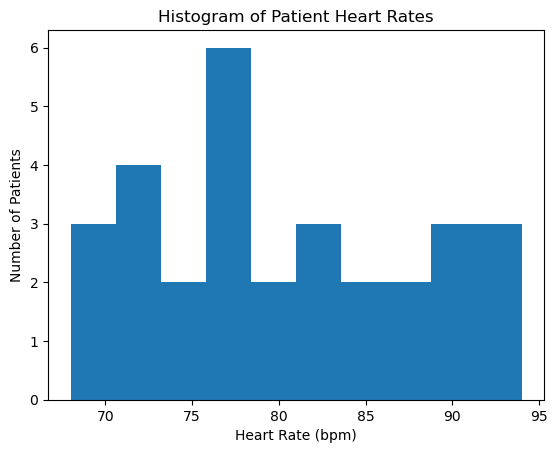

In [11]:
import matplotlib.pyplot as plt

def plot_heart_rate_histogram(data):
    """
    Plot a histogram of patient heart rates.

    Parameters:
        patients (list of dict): Patient records
    """
    heart_rates = [p["heart_rate"] for p in data]

    plt.figure()
    plt.hist(heart_rates, bins=10)
    plt.xlabel("Heart Rate (bpm)")
    plt.ylabel("Number of Patients")
    plt.title("Histogram of Patient Heart Rates")
    plt.show()

plot_heart_rate_histogram(data)


In [12]:
def classify_severity(vital_type, value):
    """
    Classify severity level for a vital sign value.

    Parameters:
        vital_type (str): 'heart_rate' or 'temperature'
        value (int | float): Vital sign value

    Returns:
        str: 'High Risk', 'Critical', or 'Normal'
    """
    if vital_type == "heart_rate":
        if value >= 100:
            return "Critical"
        elif value >= 90:
            return "High Risk"

    elif vital_type == "temperature":
        if value >= 38.5:
            return "Critical"
        elif value >= 37.8:
            return "High Risk"

    return "Normal"

In [13]:
def generate_summary_report_with_severity(data, multiplier=1.5):
    if not data:
        print("No patient data available.")
        return

    heart_rates = [p["heart_rate"] for p in data]
    temperatures = [p["temperature"] for p in data]

    hr_outliers = calculate_outliers(heart_rates)
    temp_outliers = calculate_outliers(temperatures)

    print("=== Patient Vitals Severity Report ===\n")

    print(f"{'Patient ID':<10}{'Heart Rate':<12}{'HR Severity':<12}"
          f"{'Temp':<8}{'Temp Severity'}")

    flagged = False

    for p in data:
        hr_sev = "Normal"
        temp_sev = "Normal"

        if p["heart_rate"] in hr_outliers:
            hr_sev = classify_severity("heart_rate", p["heart_rate"])

        if any(abs(p["temperature"] - t) < 0.01 for t in temp_outliers):
            temp_sev = classify_severity("temperature", p["temperature"])

        if hr_sev != "Normal" or temp_sev != "Normal":
            flagged = True
            print(f"{p['patient_id']:<10}{p['heart_rate']:<12}{hr_sev:<12}"
                  f"{p['temperature']:<8}{temp_sev}")

    if not flagged:
        print("No High Risk or Critical patients detected.")
generate_summary_report_with_severity(data, multiplier=1.5)


=== Patient Vitals Severity Report ===

Patient IDHeart Rate  HR Severity Temp    Temp Severity
108       92          Normal      38.1    High Risk
114       90          Normal      38.0    High Risk
120       94          High Risk   38.2    High Risk
126       89          Normal      37.9    High Risk
128       92          Normal      38.0    High Risk
